### Detecção de Patologias Oculares em Imagens Reflexo Vermelho Utilizando Descritores de Cor
<hr>

#### Carregar bibliotecas necessárias

In [76]:
import cv2
import glob

from matplotlib import pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis

### #1 Carregar Imagens

#### Diretório da base

<b>N_I</b> - Imagens de Reflexo Vermelho Normais <br>
<b>P_I</b> - Imagens de Reflexo Vermelho com Problemas <hr>

<b>N_M</b> - Máscaras de Reflexo Vermelho Normais <br>
<b>P_M</b> - Máscaras de Reflexo Vermelho com Problemas

In [2]:
N_I = "./data/olhos/normal"
P_I = "./data/olhos/problema"

N_M = "./data/marcacoes/normal"
P_M = "./data/marcacoes/normal"

<hr>
<b> 0 </b> - label para imagens normais <br>
<b> 1 </b> - label para imagens com problemas
<hr>

In [3]:
def carregarImgs(path_im, label):
    
    imgs, labels = [], []
    
    for img in glob.iglob(path_im + '/*.jpg'):
    
        im  = cv2.imread(img)
        im  = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                   
        imgs.append(im)
        labels.append(label)
    
    return imgs, labels

In [4]:
normais, labels_n  = carregarImgs(N_I, 0)
problema, labels_p = carregarImgs(P_I, 1)

##### Checagem das variáveis

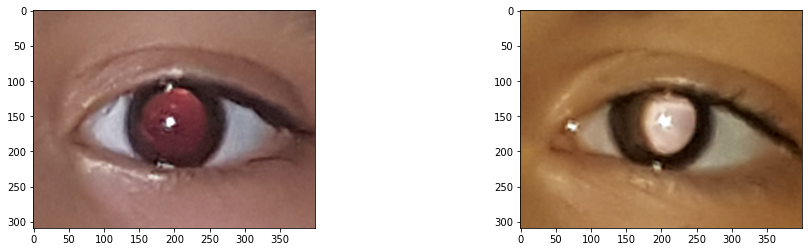

In [5]:
f, axarr = plt.subplots(1,2, figsize=(16,4))

axarr[0].imshow(normais[5])
axarr[1].imshow(problema[4])
plt.show()

### #2 Pré Processamento

3 Métodos de pré processamento possíveis de serem realizados:
<ul>
    <li>Equalização de Histograma</li>
    <li>Contraste CLAHE</li>
    <li>Cores Opostas</li>
</ul>

#### Equalização de Histograma

In [6]:
def equalizarHist(image):
    
    ch_1, ch_2, ch_3 = cv2.split(image)

    ch_1 = cv2.equalizeHist(ch_1)
    ch_2 = cv2.equalizeHist(ch_2)
    ch_3 = cv2.equalizeHist(ch_3)

    image_eq = cv2.merge((ch_1, ch_2, ch_3))
    
    return image_eq

#### Contraste CLAHE

In [18]:
def contrasteClahe(image, clip_limit = 3):
        
    image     = cv2.cvtColor(image, cv2.COLOR_RGB2LAB) 
    l, a, b   = cv2.split(image)

    clahe     = cv2.createCLAHE(clipLimit = clip_limit, tileGridSize = (8, 8))
    l_clahe   = clahe.apply(l)

    image_clahe = cv2.merge((l_clahe, a, b))
    
    image_clahe = cv2.cvtColor(image_clahe, cv2.COLOR_LAB2RGB)
        
    return image_clahe

#### Cores Opostas

In [8]:
def coresOpostas(image):
    image_CO = 255 - image
    
    return image_CO

#### Função Geral

In [26]:
def aplicarPreProc(image, metod = 'nenhum'):
    if metod == 'equalizarHist':
        return equalizarHist(image)
    elif metod == 'contrasteClahe':
        return contrasteClahe(image)
    elif metod == 'coresOpostas':
        return coresOpostas(image)
    else:
        return image

#### --------------------------- Testes -----------------------------

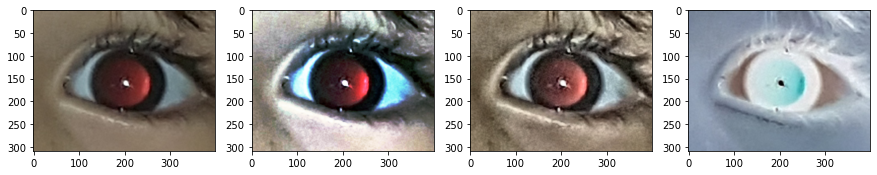

In [38]:
img_N     = aplicarPreProc(normais[7])
img_eq    = aplicarPreProc(normais[7], 'equalizarHist')
img_clahe = aplicarPreProc(normais[7], 'contrasteClahe')
img_cO    = aplicarPreProc(normais[7], 'coresOpostas')

f, axarr = plt.subplots(1,4, figsize=(15,4))

axarr[0].imshow(img_N)
axarr[1].imshow(img_eq)
axarr[2].imshow(img_clahe)
axarr[3].imshow(img_cO)
plt.show()

### #3 Espectro de Cor

3 Espectros de Cor possíveis de serem seleciodados:
<ul>
    <li>RGB</li>
    <li>HSV</li>
    <li>Lab</li>
</ul>

#### Função Geral

In [35]:
def aplicarEspectro(image, metod = 'rgb'):
    if metod == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    elif metod == 'Lab':
        return cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    else:
        return image

#### --------------------------- Testes -----------------------------

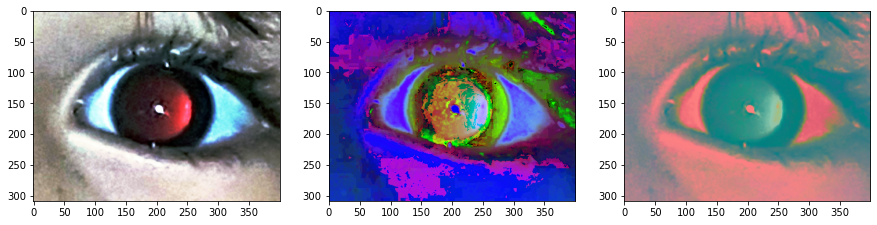

In [39]:
img_rgb    = aplicarEspectro(img_eq)
img_hsv    = aplicarEspectro(img_eq, 'HSV')
img_lab    = aplicarEspectro(img_eq, 'Lab')

f, axarr = plt.subplots(1,3, figsize=(15,4))

axarr[0].imshow(img_rgb)
axarr[1].imshow(img_hsv)
axarr[2].imshow(img_lab)
plt.show()

### #4 Aplicar Máscara

A possibilidade de aplicar ou não a máscara também será decidida pelo HyperOpt.

In [61]:
def carregarMasks(imgs, path_mk):
    
    imgs_mask = []
    
    for img, mask in zip(imgs,
                         glob.iglob(path_mk + '/*.jpg')):
        
        msk     = cv2.imread(mask, 0)
        im_mask = cv2.bitwise_and(img, img, mask = msk)
        imgs_mask.append(im_mask)
    
    return imgs_mask

#### Função Geral

In [60]:
def aplicarMask(imgs, path_mk, metod = 'nenhum'):
    if metod == 'mask':
        return carregarMasks(imgs, path_mk)
    else:
        return imgs

#### --------------------------- Testes -----------------------------

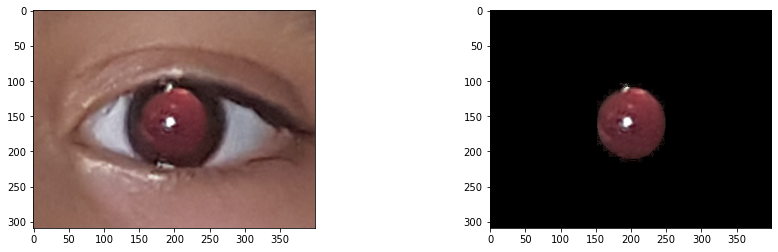

In [67]:
normais_mask = aplicarMask(normais, N_M, 'mask')

f, axarr = plt.subplots(1,2, figsize=(15,4))

axarr[0].imshow(normais[5])
axarr[1].imshow(normais_mask[5])
plt.show()

### #5. Descritores de Cor

3 Métodos Descritores de cor disponíveis para serem selecionados:
<ul>
    <li>Histograma de Cor</li>
    <li>Descritor de Cor Dominante</li>
    <li>Momentos de Cor</li>
</ul>

#### Histograma de Cor

In [14]:
def histogramadeCor(image):
    hist = []

    hist.extend(cv2.calcHist([image], [0], None, [256], [0, 256]))
    hist.extend(cv2.calcHist([image], [1], None, [256], [0, 256]))
    hist.extend(cv2.calcHist([image], [2], None, [256], [0, 256]))
    
    hist = np.concatenate(np.array(hist), axis = 0)
    
    return hist

#### Descritor de Cor Dominante

In [15]:
def corDominante(image):

    image = image.reshape((image.shape[0] * image.shape[1],3))
    clt   = KMeans(n_clusters = 4) #cluster number
    clt.fit(image)

    dominant = np.concatenate(clt.cluster_centers_, axis = 0)
    
    return dominant

#### Momentos de Cor

In [70]:
def momentosCor(image):
    
    moments = []
    
    # percorre cada canal da imagem
    # e calcula os momentos em cada canal
    for ch in cv2.split(image):
        
        # primeiro momento de cor
        mean      = np.mean(ch)
        moments.append(mean)
        
        # segundo momento de cor
        variance  = np.var(ch)
        moments.append(variance)

        # terceiro momento de cor
        skewness  = skew(ch.reshape(-1))
        moments.append(skewness)
        
        # quarto momento de cor
        kurt      = kurtosis(ch.reshape(-1))
        moments.append(kurt)
    
    moments = np.array(moments)
    
    return moments

#### Função Geral

In [69]:
def aplicarDescritor(image, metod):
    if metod == 'histogramadeCor':
        return histogramadeCor(image)
    elif metod == 'corDominante':
        return corDominante(image)
    elif metod == 'momentosCor':
        return momentosCor(image)

#### --------------------------- Testes -----------------------------

In [86]:
hist = aplicarDescritor(normais[15], 'histogramadeCor')
print(hist[10:30], type(hist))

[ 0.  0.  0.  0.  0.  0.  2.  0.  1.  4. 11. 15. 18. 19. 28. 29. 35. 51.
 69. 88.] <class 'numpy.ndarray'>


In [87]:
dominant = aplicarDescritor(normais[15], 'corDominante')
print(dominant, type(dominant))

[168.25880548 129.23063256 100.05425766 128.27374067  89.23376866
  70.79281716  61.22893027  35.73373755  29.9827631  180.64049797
 178.88719512 179.19359756] <class 'numpy.ndarray'>


In [88]:
moments = aplicarDescritor(normais[15], 'momentosCor')
print(moments, type(moments))

[ 1.51719927e+02  1.23767098e+03 -1.81045744e+00  2.86015390e+00
  1.15140777e+02  1.11909839e+03 -1.12703996e+00  1.74772445e+00
  9.09535437e+01  8.62648586e+02  6.92935556e-02  3.23268305e+00] <class 'numpy.ndarray'>
